# Fussing with Healpix

In [1]:
# 
import os
import numpy as np
import healpy as hp
import pandas

from matplotlib import pyplot as plt

from scipy import interpolate

import iris


In [2]:
%matplotlib notebook

In [3]:
noaa_path = '/home/xavier/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/'

In [4]:
def set_fontsize(ax,fsz):
    '''
    Parameters
    ----------
    ax : Matplotlib ax class
    fsz : float
      Font size
    '''
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)


# Load one

In [5]:
file_1990 = os.path.join(noaa_path, 'sst.day.mean.1990.nc')
cubes_1990 = iris.load(file_1990)
sst_1990 = cubes_1990[0]
sst_1990

<iris 'Cube' of Daily Sea Surface Temperature / (degC) (time: 365; latitude: 720; longitude: 1440)>

In [6]:
# Realize
_ = sst_1990.data

## Grab a day, any day

In [7]:
jan1_1990 = sst_1990.data[0,:,:]

In [8]:
jan1_1990.shape

(720, 1440)

## Coords

In [9]:
lat_coord = sst_1990.coord('latitude').points
lon_coord = sst_1990.coord('longitude').points

In [10]:
lat_coord[0:5]

array([-89.875, -89.625, -89.375, -89.125, -88.875], dtype=float32)

# Init Healpix

## nside

In [11]:
npix = np.product(jan1_1990.shape)
npix

1036800

In [12]:
nside_approx = np.sqrt(npix/12.)
nside_approx

293.9387691339814

In [13]:
nside = 294

In [14]:
npix_hp = hp.nside2npix(nside)
npix_hp

1037232

In [15]:
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 294 is 0.2 deg


## Init

<IPython.core.display.Javascript object>


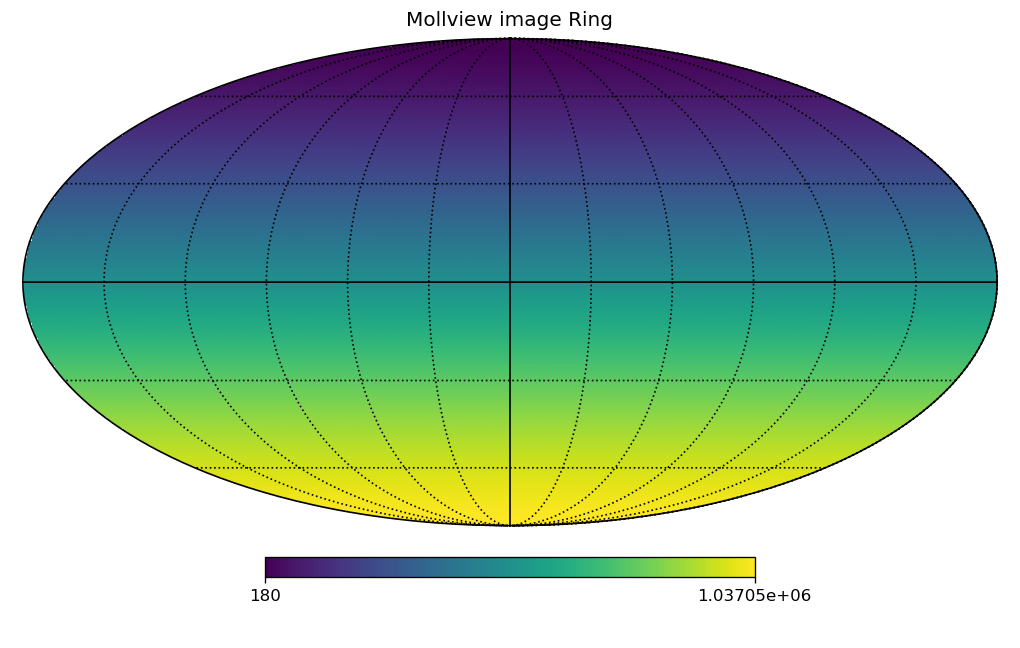

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/xavier/Projects/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


In [16]:
m = np.arange(npix_hp)
hp.mollview(m, title='Mollview image Ring')
hp.graticule()

## Angles (deg)

In [17]:
theta, phi = np.degrees(hp.pix2ang(nside=nside, ipix=np.arange(npix_hp))) #[0, 1, 2, 3, 4]))

In [18]:
theta.size

1037232

In [19]:
np.max(theta)

179.84087815269316

# Interpolate

## Mesh me

In [20]:
lat_mesh, lon_mesh = np.meshgrid(lat_coord, lon_coord, indexing='ij')

In [21]:
lat_mesh.shape

(720, 1440)

In [22]:
jan1_1990.shape

(720, 1440)

In [23]:
jan1_1990.fill_value = -10.
jan1_1990

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094],
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094],
        [-1.71999990940094, -1.71999990940094, -1.71999990940094, ...,
         -1.71999990940094, -1.71999990940094, -1.71999990940094]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-10.0,
  dtype=float32)

## Interpolate

In [24]:
func = interpolate.RectBivariateSpline(lat_coord, lon_coord, jan1_1990.filled(), kx=2, ky=2)#, epsilon=2)

In [25]:
new_SST = func.ev(90-theta, phi)

In [26]:
new_SST.shape

(1037232,)

## Plot

<IPython.core.display.Javascript object>


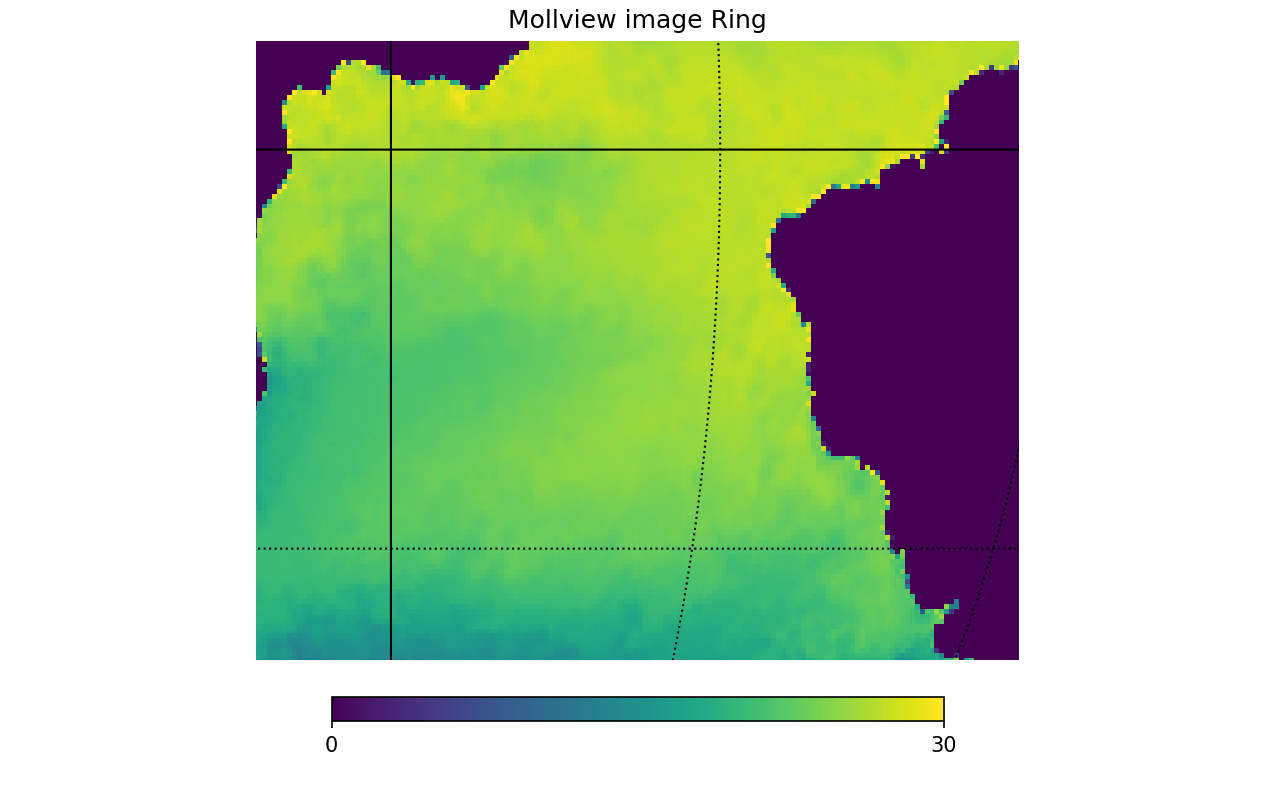

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [35]:
#m = np.arange(npix_hp)
hp.mollview(new_SST, title='Mollview image Ring', max=30., min=0.)
hp.graticule()

# Harmonics

## Mask

In [28]:
goodpix = new_SST > -5.
np.mean(new_SST[goodpix])

17.752369657531112

## Remove the monopole

In [29]:
diff_SST = new_SST - np.mean(new_SST[goodpix])

In [30]:
diff_SST[~goodpix] = 0.

## Calculate

In [31]:
cls = hp.sphtfunc.anafast(diff_SST)

In [32]:
cls.size

882

## Plot

In [33]:
ls = np.arange(cls.size)

<IPython.core.display.Javascript object>


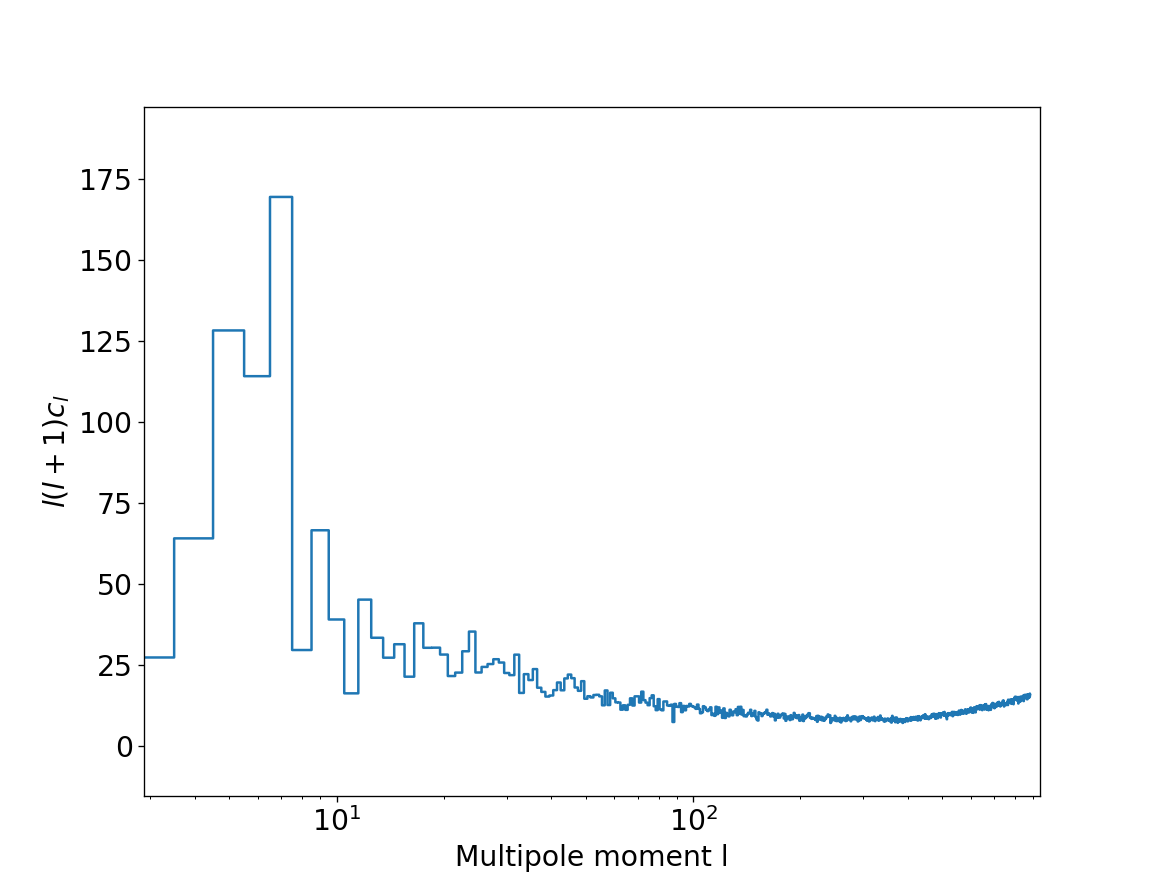

In [34]:
plt.clf()
ax = plt.gca()
ax.plot(ls, ls*(ls+1)*cls, drawstyle='steps-mid')
#
ax.set_xscale('log')
ax.set_xlim(1.,1000)
ax.set_xlabel('Multipole moment l')
ax.set_ylabel(r'$l(l+1)c_l$')
set_fontsize(ax,17)
plt.show()

# Save

In [ ]:

    # Write
    t = Table()
    t['flux'] = DM_tot  # the data array
    t.meta['ORDERING'] = 'RING'
    t.meta['COORDSYS'] = 'G'
    t.meta['NSIDE'] = 1024
    t.meta['INDXSCHM'] = 'IMPLICIT'
    t.write(hp_file, overwrite=True)